# Análise de sentimentos do Twitter e bolsa de valores: uma investigação sobre a correlação entre estes dois sistemas

## Arquivo 3: Preprocessamento e Machine Learning

Este módulo consiste em:

    * 1. Fazer a leitura dos dados
    * 2. Fazer o preprocessamento dos dados
    * 3. Extrair features
    * 4. Aplicar modelos de machine learning
    
#### Importando bibliotecas

In [34]:
#Para maniputacao de arrays
import numpy as np
#Manipulacao de dados
import pandas as pd
#Import Natural Language Toolkit
import nltk #to usando mesmo? SIM
nltk.download('rslp')
nltk.download('stopwords')
#Import the stop word list
#from langdetect import detect
#Import Tokenizer
from nltk.tokenize import RegexpTokenizer
#Import regex
import re
#Beleza
import seaborn as sns
#Matplotlib
import matplotlib.pyplot as plt

#MACHINE LEARNING FUNCTIONS FROM SKLEARN
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

%matplotlib inline

sns.set_style('whitegrid')
sns.set_palette('coolwarm')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### DEFININDO FUNÇÕES

* Preprocessamento de texto

In [35]:
RANDOM_STATE = 22

In [36]:
def remove_links(text):
    return re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def remove_arroba(text):
    text = re.sub('@[^\s]+','',text)
    text = re.sub('#[^\s]+','',text)
    text = re.sub('$[^\s]+','',text)
    return text

def remove_ponctuation(text):
    return re.sub(r'[^\w\s]',' ',text)

def remove_breaklines(text):
    text = text.split('\n')
    return ''.join(text)

def remove_numbers(text):
    text = re.sub(" \d+", ' ', text)
    return re.sub("\d+", ' ', text)

def extra_spaces(text):
    return re.sub(' +',' ',text).lstrip().rstrip()

def stopwords_removal(text):
    words = nltk.corpus.stopwords.words('portuguese')
    text = [t for t in text.split() if t not in words]
    return ' '.join(text)

def stemming (text):
    stemmer = nltk.stem.RSLPStemmer()
    text = [stemmer.stem(t) for t in text.split()]
    return ' '.join(text)

def ruido_len1 (text):
    text = [t for t in text.split() if len(t) > 1]
    return ' '.join(text)

def text_processing(text):
    """
        Text processing steps:
        1. Lowering of text
        2. Remove Hyperlinks
        3. Remove metions such as @, # and $
        4. Remove breaklines \n
        5. Remove punctuation
        6. Remove numbers
    """
    
    #lowercase text
    text = text.lower()
    
    #remove hyperlinks
    text = remove_links(text)
    
    #remove @mentions, #hashtags and $tickers
    text = remove_arroba(text)
    
    #remove breaklines
    text = remove_breaklines(text)
    
    #remove ponctuation
    text = remove_ponctuation(text)
    
    #remove numbers
    text = remove_numbers(text)
    
    text = stopwords_removal(text)
    
    text = stemming(text)
    
    text = ruido_len1(text)
    
    #remove extra spaces
    text = extra_spaces(text)
    
    return text

In [37]:


from datetime import datetime, timedelta

def sum_date(date_str, days=1):
    aux = datetime.strptime(date_str, '%Y-%m-%d') + timedelta(days=days)
    return aux.strftime('%Y-%m-%d')


def create_dataframeTfidfTarget (df_twitter, df_finance, window_days=1, column=''):
    
    #Setting variables
    start_date = '2019-01-01'; end_date = '2019-05-31'
    flag = 0; mean_list = []; 

    final_dataframe = pd.DataFrame(columns='change'.split())

    #Rodar até data x ou flag==5
    while(flag < 5 or start_date!=end_date):
        
        #Dentro do loop se começa
        aux_day = start_date
        start_date = sum_date(start_date, 1)

        aux_vectors = pd.DataFrame(columns = [column])
        
        # Pegar vetores na janela de dias
        for j in range(window_days):
            aux_vectors = aux_vectors.append(df_twitter[df_twitter['data'] == aux_day])
            aux_day = sum_date(aux_day, 1)
        
        if aux_vectors.empty:
            continue
        
        mean_list.append(aux_vectors['text'].values.tolist())

        #Pegar data janela+1dia
        flag = 0
        
        while(df_finance[df_finance.index == aux_day].empty):
            flag +=1
            aux_day = sum_date(aux_day, 1)
            if flag == 10:
                mean_list.pop()
                break
        
        if flag != 10:
            final_dataframe = final_dataframe.append(df_finance[df_finance.index == aux_day])
    
    X = []; y = []
    aux = final_dataframe[column].values
    
    for i, idx in enumerate(mean_list):
        for j, jdx in enumerate(idx):
            X.append(jdx)
            y.append(aux[i])
            #aux = np.append(aux, aux[i])
            #y.append(aux)
    
    return X, y

In [7]:
def using_all_together(X_train, X_test, y_train, y_test):
    
    #Construindo Pipelines
                    
    pipe_lr = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=100000))])

    pipe_rf = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(random_state=RANDOM_STATE))])


    pipe_svm = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                ('clf', SVC(random_state=RANDOM_STATE))])

    # Parâmetros Grid Search
    param_range = [4, 8, 16]
    param_range_fl = [0.01, 1.0, 10, 100]

    grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
            'clf__C': param_range_fl,
            'clf__solver': ['liblinear']}] 


    grid_params_rf = [{'clf__criterion': ['gini'],
            'clf__max_depth': param_range,
            'clf__min_samples_split': param_range[1:]}]

    grid_params_svm = [{'clf__kernel': ['rbf'], 
            'clf__C': param_range_fl}]

    # Construindo Grid Search

    LR = GridSearchCV(pipe_lr, param_grid=grid_params_lr, scoring='accuracy', cv=10) 

    RF = GridSearchCV(pipe_rf, param_grid=grid_params_rf, scoring='accuracy', cv=10, n_jobs=-1)

    SVM = GridSearchCV(pipe_svm, param_grid=grid_params_svm, scoring='accuracy', cv=10, n_jobs=-1)

    # Lista de pipelines para iterar
    grids = [LR,RF,SVM]

    grid_dict = {0: 'Logistic Regression', 
            1: 'Random Forest',
            2: 'Support Vector Machine'}

    # Encontrar melhor estimador
    print('Executando pipelines com gridsearch...')
    best_acc = 0.0
    best_clf = 0
    best_gs = ''
    
    for idx, gs in enumerate(grids):
        
        gs.fit(X_train, y_train)
        print('\nClassificador: {}'.format(grid_dict[idx]))
        print('Melhores parâmetros: {}'.format(gs.best_params_))
        print('Acurácia treinamento {:.2}'.format(gs.best_score_))
        
        #Predicao do melhor gridsearch
        y_pred = gs.predict(X_test)
        
        # Test data accuracy of model with best params
        print('Acurácia no teste: {:2.2}'.format(accuracy_score(y_test, y_pred)))
        print('Confusion matrix: \n {}'.format(confusion_matrix(y_pred, y_test)))
        print('Classification Report: \n {}'.format(classification_report(y_pred, y_test)))
        
        # Salvar modelo melhor acuracia
        if accuracy_score(y_test, y_pred) > best_acc:
            best_acc = accuracy_score(y_test, y_pred)
            best_gs = gs
            best_clf = idx
    print('\nClassificador com melhor acurácia no teste: {:}'.format(grid_dict[best_clf]))

# Experimento

## 1. Leitura dos dados

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
#PETR4
petr4_financas = pd.read_csv(open('/content/drive/My Drive/código-fonte/database/finance/Petrobras.csv', 'r'), index_col=0)
petr4_twitter = pd.read_csv(open('/content/drive/My Drive/código-fonte/database/twitter/Petrobras.csv', 'r'), index_col = 0)

#Magazine Luisa
mgu_financas = pd.read_csv(open('/content/drive/My Drive/código-fonte/database/finance/Magazine Luisa SA.csv'), index_col=0)
mgu_twitter = pd.read_csv(open('/content/drive/My Drive/código-fonte/database/twitter/Magalu.csv'), index_col = 0)

#IRB Brasil Seguros
irb_financas = pd.read_csv(open('/content/drive/My Drive/código-fonte/database/finance/IRB Brasil Seguros.csv'), index_col=0)
irb_twitter = pd.read_csv(open('/content/drive/My Drive/código-fonte/database/twitter/IRB_Brasil_Seguros.csv'), index_col=0)

#B3
b3_financas = pd.read_csv(open('/content/drive/My Drive/código-fonte/database/finance/B3.csv'), index_col=0)
b3_twitter = pd.read_csv(open('/content/drive/My Drive/código-fonte/database/twitter/B3.csv'), index_col = 0)

## 2. Preprocessamento

In [40]:
petr4_twitter['text'] = petr4_twitter['text'].apply(text_processing)
petr4_twitter['data'] = petr4_twitter['date'].apply(lambda x: x.split()[0])
petr4_financas['change'] = petr4_financas['Close'].pct_change()

mgu_twitter['text'] = mgu_twitter['text'].apply(text_processing)
mgu_twitter['data'] = mgu_twitter['date'].apply(lambda x: x.split()[0])
mgu_financas['change'] = mgu_financas['Close'].pct_change()

irb_twitter['text'] = irb_twitter['text'].apply(text_processing)
irb_twitter['data'] = irb_twitter['date'].apply(lambda x: x.split()[0])
irb_financas['change'] = irb_financas['Close'].pct_change()

b3_twitter['text'] = b3_twitter['text'].apply(text_processing)
b3_twitter['data'] = b3_twitter['date'].apply(lambda x: x.split()[0])
b3_financas['change'] = b3_financas['Close'].pct_change()

## 3. Extração de Features

* Criando colunas retorno e label para finanças
* Definindo label para tweets

### Gráfico de densidade da variação das finanças PETR4

Text(0, 0.5, 'Densidade')

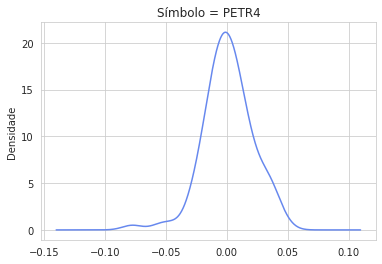

In [25]:
plt.title('Símbolo = PETR4')
petr4_financas['change'].plot.density()
plt.ylabel('Densidade')

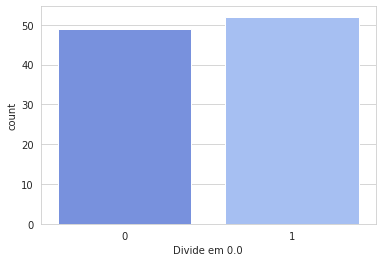

In [26]:
petr4_financas['Divide em 0.0'] = petr4_financas['change'].apply(lambda x: 0 if x < 0 else 1)
sns.countplot(x='Divide em 0.0', data=petr4_financas)

### Gráfico de densidade da variação das finanças MGLU3

Text(0, 0.5, 'Densidade')

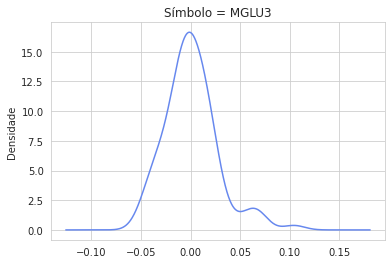

In [11]:
plt.title('Símbolo = MGLU3')
mgu_financas['change'].plot.density()
plt.ylabel('Densidade')

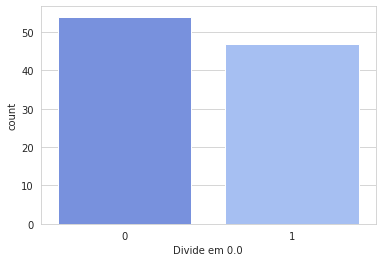

In [13]:
mgu_financas['Divide em 0.0'] = mgu_financas['change'].apply(lambda x: 0 if x < 0 else 1)
sns.countplot(x='Divide em 0.0', data=mgu_financas)

### Gráfico de densidade da variação das finanças IRB

> Bloco com recuo



Text(0, 0.5, 'Densidade')

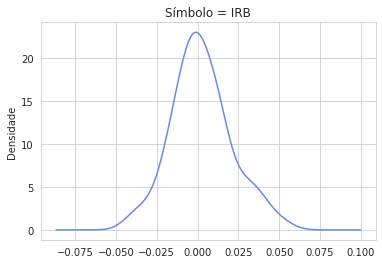

In [14]:
plt.title('Símbolo = IRB')
irb_financas['change'].plot.density()
plt.ylabel('Densidade')

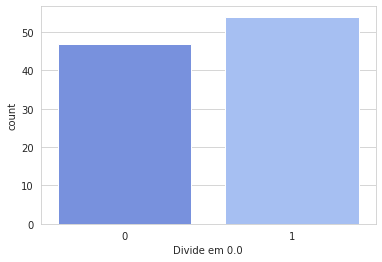

In [44]:
irb_financas['Divide em 0.0'] = irb_financas['change'].apply(lambda x: 0 if x < 0 else 1)
sns.countplot(x='Divide em 0.0', data=irb_financas)

### Gráfico de densidade da variação das finanças B3

Text(0, 0.5, 'Densidade')

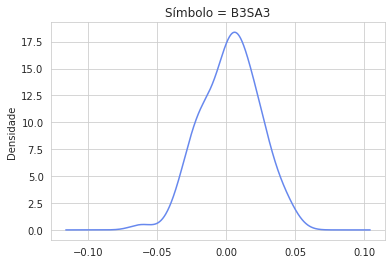

In [41]:
plt.title('Símbolo = B3SA3')
b3_financas['change'].plot.density()
plt.ylabel('Densidade')

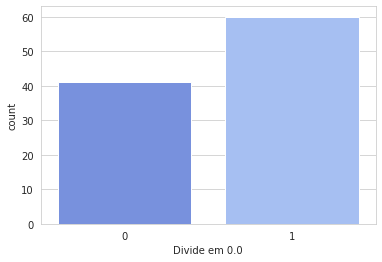

In [46]:
b3_financas['Divide em 0.0'] = b3_financas['change'].apply(lambda x: 0 if x < 0 else 1)
sns.countplot(x='Divide em 0.0', data=b3_financas)

## 4. Machine Learning

* Testarei primeiro com split RANDOM e depois 70%-30% CONTÍNUO

### #PETR4 RANDOM_SPLIT

WINDOWS_DAYS = 1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


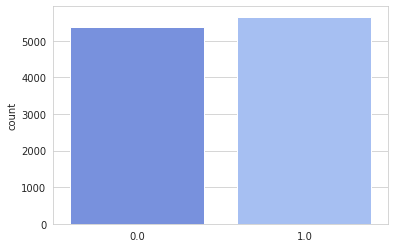

In [38]:
# Getting data

#WINDOWS DAYS = 1 e TRAIN_TEST_SPLIT RANDOM
X_petr4, y_petr4 = create_dataframeTfidfTarget(petr4_twitter, petr4_financas, window_days=1, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_petr4, y_petr4, stratify=y_petr4, test_size=0.3, random_state=RANDOM_STATE)

sns.countplot(y_petr4)

In [39]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.71
Acurácia no teste: 0.72
Confusion matrix: 
 [[1204  518]
 [ 409 1180]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.75      0.70      0.72      1722
         1.0       0.69      0.74      0.72      1589

    accuracy                           0.72      3311
   macro avg       0.72      0.72      0.72      3311
weighted avg       0.72      0.72      0.72      3311


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_split': 8}
Acurácia treinamento 0.7
Acurácia no teste: 0.71
Confusion matrix: 
 [[ 943  300]
 [ 670 1398]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.58      0.76      0.66      1243
         1.0       0.82      0.

WINDOWS DAYS=2

In [30]:
# Getting data

#WINDOWS DAYS = 2 e TRAIN_TEST_SPLIT RANDOM
X_petr4, y_petr4 = create_dataframeTfidfTarget(petr4_twitter, petr4_financas, window_days=2, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_petr4, y_petr4, stratify=y_petr4, test_size=0.3, random_state=RANDOM_STATE)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


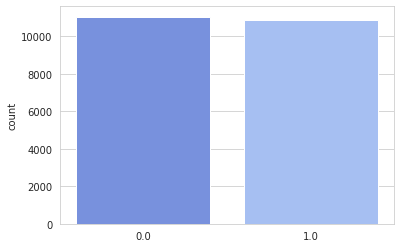

In [31]:
sns.countplot(y_petr4)

In [32]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.66
Acurácia no teste: 0.66
Confusion matrix: 
 [[2390 1297]
 [ 924 1969]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.72      0.65      0.68      3687
         1.0       0.60      0.68      0.64      2893

    accuracy                           0.66      6580
   macro avg       0.66      0.66      0.66      6580
weighted avg       0.67      0.66      0.66      6580


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_split': 12}
Acurácia treinamento 0.65
Acurácia no teste: 0.65
Confusion matrix: 
 [[2195 1169]
 [1119 2097]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.66      0.65      0.66      3364
         1.0       0.64      

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Classificador: Support Vector Machine
Melhores parâmetros: {'clf__C': 10, 'clf__kernel': 'linear'}
Acurácia treinamento 0.66
Acurácia no teste: 0.67
Confusion matrix: 
 [[2420 1302]
 [ 894 1964]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.73      0.65      0.69      3722
         1.0       0.60      0.69      0.64      2858

    accuracy                           0.67      6580
   macro avg       0.67      0.67      0.66      6580
weighted avg       0.67      0.67      0.67      6580


Classificador com melhor acurácia no teste: Support Vector Machine


WINDOWS_DAYS = 3

In [34]:
# Getting data

#WINDOWS DAYS = 3 e TRAIN_TEST_SPLIT RANDOM
X_petr4, y_petr4 = create_dataframeTfidfTarget(petr4_twitter, petr4_financas, window_days=3, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_petr4, y_petr4, stratify=y_petr4, test_size=0.3, random_state=RANDOM_STATE)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


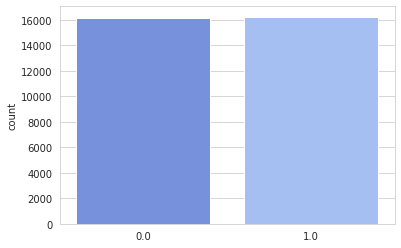

In [35]:
sns.countplot(y_petr4)

In [36]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 100, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.67
Acurácia no teste: 0.67
Confusion matrix: 
 [[3609 1929]
 [1250 2949]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.74      0.65      0.69      5538
         1.0       0.60      0.70      0.65      4199

    accuracy                           0.67      9737
   macro avg       0.67      0.68      0.67      9737
weighted avg       0.68      0.67      0.68      9737


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_split': 8}
Acurácia treinamento 0.64
Acurácia no teste: 0.64
Confusion matrix: 
 [[2965 1604]
 [1894 3274]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.61      0.65      0.63      4569
         1.0       0.67      

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Classificador: Support Vector Machine
Melhores parâmetros: {'clf__C': 1.0, 'clf__kernel': 'rbf'}
Acurácia treinamento 0.68
Acurácia no teste: 0.68
Confusion matrix: 
 [[3574 1843]
 [1285 3035]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.74      0.66      0.70      5417
         1.0       0.62      0.70      0.66      4320

    accuracy                           0.68      9737
   macro avg       0.68      0.68      0.68      9737
weighted avg       0.69      0.68      0.68      9737


Classificador com melhor acurácia no teste: Support Vector Machine


### Petrobrás NOT RANDOM

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


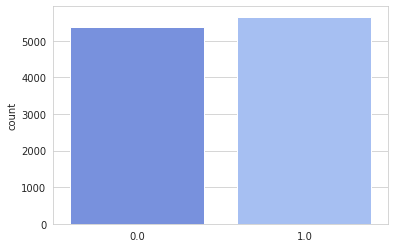

In [40]:
# Getting data

#WINDOWS DAYS = 1 e TRAIN_TEST_SPLIT NOT RANDOM
X_petr4, y_petr4 = create_dataframeTfidfTarget(petr4_twitter, petr4_financas, window_days=1, column='Divide em 0.0')

# using train_test_split NOT RANDOM
size = round(len(X_petr4)*0.7)
X_train = X_petr4[:size]
X_test = X_petr4[size:]
y_train = y_petr4[:size]
y_test = y_petr4[size:]
sns.countplot(y_petr4)

In [41]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.54
Acurácia no teste: 0.52
Confusion matrix: 
 [[1060  867]
 [ 708  676]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.60      0.55      0.57      1927
         1.0       0.44      0.49      0.46      1384

    accuracy                           0.52      3311
   macro avg       0.52      0.52      0.52      3311
weighted avg       0.53      0.52      0.53      3311


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_split': 16}
Acurácia treinamento 0.52
Acurácia no teste: 0.54
Confusion matrix: 
 [[ 478  249]
 [1290 1294]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.27      0.66      0.38       727
         1.0       0.84     

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


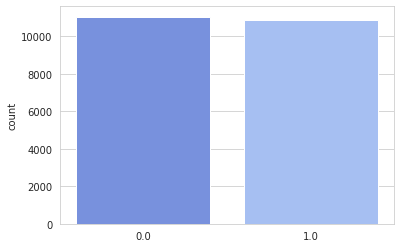

In [42]:
# Getting data

#WINDOWS DAYS = 2 e TRAIN_TEST_SPLIT NOT RANDOM
X_petr4, y_petr4 = create_dataframeTfidfTarget(petr4_twitter, petr4_financas, window_days=2, column='Divide em 0.0')

# using train_test_split NOT RANDOM
size = round(len(X_petr4)*0.7)
X_train = X_petr4[:size]
X_test = X_petr4[size:]
y_train = y_petr4[:size]
y_test = y_petr4[size:]
sns.countplot(y_petr4)

In [43]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.53
Acurácia no teste: 0.41
Confusion matrix: 
 [[   0    0]
 [3895 2685]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.41      0.58      6580

    accuracy                           0.41      6580
   macro avg       0.50      0.20      0.29      6580
weighted avg       1.00      0.41      0.58      6580



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_split': 16}
Acurácia treinamento 0.52
Acurácia no teste: 0.41
Confusion matrix: 
 [[  82   40]
 [3813 2645]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.02      0.67      0.04       122
         1.0       0.99      0.41      0.58      6458

    accuracy                           0.41      6580
   macro avg       0.50      0.54      0.31      6580
weighted avg       0.97      0.41      0.57      6580



/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Classificador: Support Vector Machine
Melhores parâmetros: {'clf__C': 0.01, 'clf__kernel': 'rbf'}
Acurácia treinamento 0.51
Acurácia no teste: 0.41
Confusion matrix: 
 [[  76   38]
 [3819 2647]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.02      0.67      0.04       114
         1.0       0.99      0.41      0.58      6466

    accuracy                           0.41      6580
   macro avg       0.50      0.54      0.31      6580
weighted avg       0.97      0.41      0.57      6580


Classificador com melhor acurácia no teste: Random Forest


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


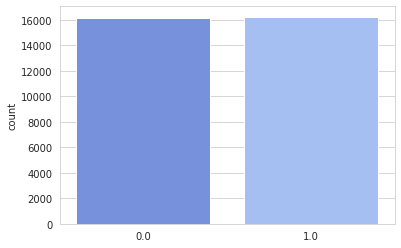

In [44]:
# Getting data

#WINDOWS DAYS = 3 e TRAIN_TEST_SPLIT NOT RANDOM
X_petr4, y_petr4 = create_dataframeTfidfTarget(petr4_twitter, petr4_financas, window_days=3, column='Divide em 0.0')

# using train_test_split NOT RANDOM
size = round(len(X_petr4)*0.7)
X_train = X_petr4[:size]
X_test = X_petr4[size:]
y_train = y_petr4[:size]
y_test = y_petr4[size:]
sns.countplot(y_petr4)

In [45]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.54
Acurácia no teste: 0.41
Confusion matrix: 
 [[   0    0]
 [5760 3977]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.41      0.58      9737

    accuracy                           0.41      9737
   macro avg       0.50      0.20      0.29      9737
weighted avg       1.00      0.41      0.58      9737



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_split': 8}
Acurácia treinamento 0.54
Acurácia no teste: 0.41
Confusion matrix: 
 [[   2    1]
 [5758 3976]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.67      0.00         3
         1.0       1.00      0.41      0.58      9734

    accuracy                           0.41      9737
   macro avg       0.50      0.54      0.29      9737
weighted avg       1.00      0.41      0.58      9737



/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Classificador: Support Vector Machine
Melhores parâmetros: {'clf__C': 0.01, 'clf__kernel': 'rbf'}
Acurácia treinamento 0.52
Acurácia no teste: 0.41
Confusion matrix: 
 [[  95   57]
 [5665 3920]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.02      0.62      0.03       152
         1.0       0.99      0.41      0.58      9585

    accuracy                           0.41      9737
   macro avg       0.50      0.52      0.31      9737
weighted avg       0.97      0.41      0.57      9737


Classificador com melhor acurácia no teste: Support Vector Machine


### MGLU3 RANDOM SPLIT

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


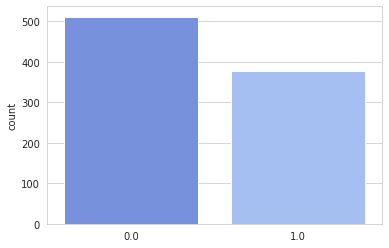

In [33]:
# Getting data

#WINDOWS DAYS = 1 e TRAIN_TEST_SPLIT RANDOM
X_mglu3, y_mglu3 = create_dataframeTfidfTarget(mgu_twitter, mgu_financas, window_days=1, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_mglu3, y_mglu3, stratify=y_mglu3, test_size=0.3, random_state=RANDOM_STATE)
sns.countplot(y_mglu3)

In [38]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.7
Acurácia no teste: 0.66
Confusion matrix: 
 [[111  47]
 [ 43  66]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.72      0.70      0.71       158
         1.0       0.58      0.61      0.59       109

    accuracy                           0.66       267
   macro avg       0.65      0.65      0.65       267
weighted avg       0.66      0.66      0.66       267


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_split': 8}
Acurácia treinamento 0.64
Acurácia no teste: 0.64
Confusion matrix: 
 [[100  41]
 [ 54  72]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.65      0.71      0.68       141
         1.0       0.64      0.57      0.60       126

    accuracy           

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


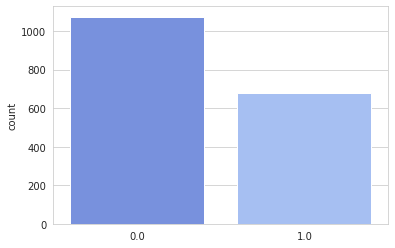

In [39]:
# Getting data

#WINDOWS DAYS = 2 e TRAIN_TEST_SPLIT RANDOM
X_mglu3, y_mglu3 = create_dataframeTfidfTarget(mgu_twitter, mgu_financas, window_days=2, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_mglu3, y_mglu3, stratify=y_mglu3, test_size=0.3, random_state=RANDOM_STATE)
sns.countplot(y_mglu3)

In [40]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.68
Acurácia no teste: 0.72
Confusion matrix: 
 [[249  76]
 [ 73 128]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.77      0.77      0.77       325
         1.0       0.63      0.64      0.63       201

    accuracy                           0.72       526
   macro avg       0.70      0.70      0.70       526
weighted avg       0.72      0.72      0.72       526


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_split': 16}
Acurácia treinamento 0.67
Acurácia no teste: 0.68
Confusion matrix: 
 [[291 138]
 [ 31  66]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      0.68      0.77       429
         1.0       0.32      0.68      0.44        97

    accuracy         

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


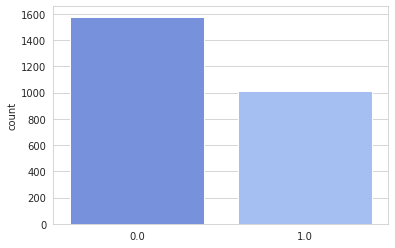

In [41]:
# Getting data

#WINDOWS DAYS = 3 e TRAIN_TEST_SPLIT RANDOM
X_mglu3, y_mglu3 = create_dataframeTfidfTarget(mgu_twitter, mgu_financas, window_days=3, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_mglu3, y_mglu3, stratify=y_mglu3, test_size=0.3, random_state=RANDOM_STATE)
sns.countplot(y_mglu3)

In [42]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.72
Acurácia no teste: 0.7
Confusion matrix: 
 [[380 142]
 [ 94 161]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.80      0.73      0.76       522
         1.0       0.53      0.63      0.58       255

    accuracy                           0.70       777
   macro avg       0.67      0.68      0.67       777
weighted avg       0.71      0.70      0.70       777


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_split': 8}
Acurácia treinamento 0.7
Acurácia no teste: 0.68
Confusion matrix: 
 [[416 189]
 [ 58 114]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.69      0.77       605
         1.0       0.38      0.66      0.48       172

    accuracy           

### MGLU NOT RANDOM


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


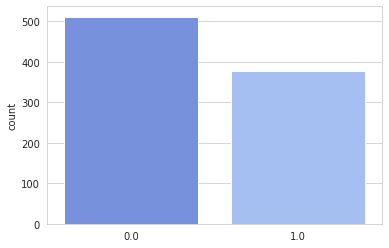

In [18]:
# Getting data

#WINDOWS DAYS = 1 e TRAIN_TEST_SPLIT RANDOM
X_mglu3, y_mglu3 = create_dataframeTfidfTarget(mgu_twitter, mgu_financas, window_days=1, column='Divide em 0.0')

# using train_test_split NOT RANDOM
size = round(len(X_mglu3)*0.7)
X_train = X_mglu3[:size]
X_test = X_mglu3[size:]
y_train = y_mglu3[:size]
y_test = y_mglu3[size:]
sns.countplot(y_mglu3)

In [19]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.67
Acurácia no teste: 0.36
Confusion matrix: 
 [[ 95 171]
 [  0   0]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.36      0.53       266
         1.0       0.00      0.00      0.00         0

    accuracy                           0.36       266
   macro avg       0.50      0.18      0.26       266
weighted avg       1.00      0.36      0.53       266



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_split': 8}
Acurácia treinamento 0.67
Acurácia no teste: 0.36
Confusion matrix: 
 [[ 95 171]
 [  0   0]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.36      0.53       266
         1.0       0.00      0.00      0.00         0

    accuracy                           0.36       266
   macro avg       0.50      0.18      0.26       266
weighted avg       1.00      0.36      0.53       266



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Support Vector Machine
Melhores parâmetros: {'clf__C': 0.01, 'clf__kernel': 'rbf'}
Acurácia treinamento 0.67
Acurácia no teste: 0.36
Confusion matrix: 
 [[ 95 171]
 [  0   0]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.36      0.53       266
         1.0       0.00      0.00      0.00         0

    accuracy                           0.36       266
   macro avg       0.50      0.18      0.26       266
weighted avg       1.00      0.36      0.53       266


Classificador com melhor acurácia no teste: Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


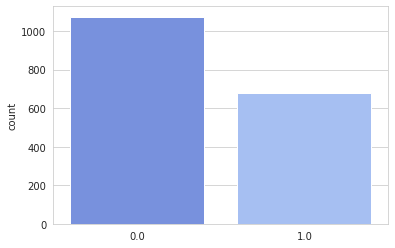

In [20]:
# Getting data

#WINDOWS DAYS = 2 e TRAIN_TEST_SPLIT RANDOM
X_mglu3, y_mglu3 = create_dataframeTfidfTarget(mgu_twitter, mgu_financas, window_days=2, column='Divide em 0.0')

# using train_test_split NOT RANDOM
size = round(len(X_mglu3)*0.7)
X_train = X_mglu3[:size]
X_test = X_mglu3[size:]
y_train = y_mglu3[:size]
y_test = y_mglu3[size:]
sns.countplot(y_mglu3)

In [21]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.7
Acurácia no teste: 0.41
Confusion matrix: 
 [[218 308]
 [  0   0]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.41      0.59       526
         1.0       0.00      0.00      0.00         0

    accuracy                           0.41       526
   macro avg       0.50      0.21      0.29       526
weighted avg       1.00      0.41      0.59       526



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_split': 16}
Acurácia treinamento 0.7
Acurácia no teste: 0.41
Confusion matrix: 
 [[218 308]
 [  0   0]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.41      0.59       526
         1.0       0.00      0.00      0.00         0

    accuracy                           0.41       526
   macro avg       0.50      0.21      0.29       526
weighted avg       1.00      0.41      0.59       526



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Support Vector Machine
Melhores parâmetros: {'clf__C': 0.01, 'clf__kernel': 'rbf'}
Acurácia treinamento 0.7
Acurácia no teste: 0.41
Confusion matrix: 
 [[218 308]
 [  0   0]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.41      0.59       526
         1.0       0.00      0.00      0.00         0

    accuracy                           0.41       526
   macro avg       0.50      0.21      0.29       526
weighted avg       1.00      0.41      0.59       526


Classificador com melhor acurácia no teste: Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


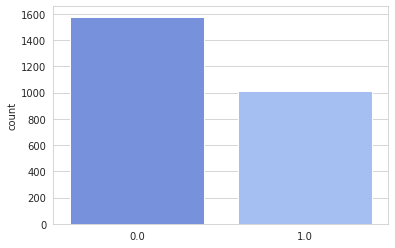

In [23]:
# Getting data

#WINDOWS DAYS = 3 e TRAIN_TEST_SPLIT RANDOM
X_mglu3, y_mglu3 = create_dataframeTfidfTarget(mgu_twitter, mgu_financas, window_days=3, column='Divide em 0.0')

# using train_test_split NOT RANDOM
size = round(len(X_mglu3)*0.7)
X_train = X_mglu3[:size]
X_test = X_mglu3[size:]
y_train = y_mglu3[:size]
y_test = y_mglu3[size:]
sns.countplot(y_mglu3)

In [24]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.71
Acurácia no teste: 0.41
Confusion matrix: 
 [[268 431]
 [ 25  53]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.91      0.38      0.54       699
         1.0       0.11      0.68      0.19        78

    accuracy                           0.41       777
   macro avg       0.51      0.53      0.36       777
weighted avg       0.83      0.41      0.51       777


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_split': 16}
Acurácia treinamento 0.72
Acurácia no teste: 0.38
Confusion matrix: 
 [[291 483]
 [  2   1]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.99      0.38      0.55       774
         1.0       0.00      0.33   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### IRB RANDOM SPLIT

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


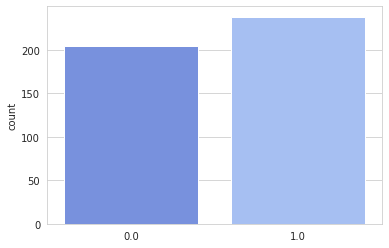

In [26]:
# Getting data

#WINDOWS DAYS = 1 e TRAIN_TEST_SPLIT RANDOM
X_irb, y_irb = create_dataframeTfidfTarget(irb_twitter, irb_financas, window_days=1, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_irb, y_irb, stratify=y_irb, test_size=0.3, random_state=RANDOM_STATE)
sns.countplot(y_irb)

In [27]:
using_all_together(X_train, X_test, y_train, y_test)

Executando pipelines com gridsearch...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.63
Acurácia no teste: 0.56
Confusion matrix: 
 [[21 19]
 [40 53]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.34      0.53      0.42        40
         1.0       0.74      0.57      0.64        93

    accuracy                           0.56       133
   macro avg       0.54      0.55      0.53       133
weighted avg       0.62      0.56      0.57       133


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_split': 16}
Acurácia treinamento 0.64
Acurácia no teste: 0.57
Confusion matrix: 
 [[14 10]
 [47 62]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.23      0.58      0.33        24
         1.0       0.86      0.57      0.69       109

    accuracy                 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.63
Acurácia no teste: 0.6
Confusion matrix: 
 [[ 39  35]
 [ 70 121]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.36      0.53      0.43        74
         1.0       0.78      0.63      0.70       191

    accuracy                           0.60       265
   macro avg       0.57      0.58      0.56       265
weighted avg       0.66      0.60      0.62       265


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_split': 8}
Acurácia treinamento 0.6
Acurácia no teste: 0.58
Confusion matrix: 
 [[  4   6]
 [105 150]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.04      0.40      0.07        10
         1.0       0.96      0.59      0

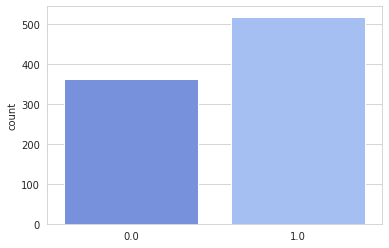

In [28]:
# Getting data

#WINDOWS DAYS = 2 e TRAIN_TEST_SPLIT RANDOM
X_irb, y_irb = create_dataframeTfidfTarget(irb_twitter, irb_financas, window_days=2, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_irb, y_irb, stratify=y_irb, test_size=0.3, random_state=RANDOM_STATE)
sns.countplot(y_irb)
using_all_together(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.64
Acurácia no teste: 0.66
Confusion matrix: 
 [[ 69  44]
 [ 91 192]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.43      0.61      0.51       113
         1.0       0.81      0.68      0.74       283

    accuracy                           0.66       396
   macro avg       0.62      0.64      0.62       396
weighted avg       0.70      0.66      0.67       396


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_split': 8}
Acurácia treinamento 0.62
Acurácia no teste: 0.64
Confusion matrix: 
 [[ 23   7]
 [137 229]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.14      0.77      0.24        30
         1.0       0.97      0.63     

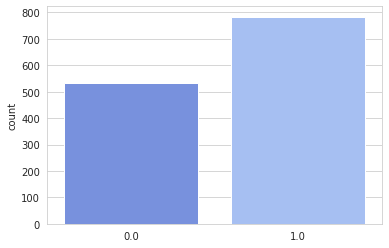

In [29]:
# Getting data

#WINDOWS DAYS = 3 e TRAIN_TEST_SPLIT RANDOM
X_irb, y_irb = create_dataframeTfidfTarget(irb_twitter, irb_financas, window_days=3, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_irb, y_irb, stratify=y_irb, test_size=0.3, random_state=RANDOM_STATE)
sns.countplot(y_irb)
using_all_together(X_train, X_test, y_train, y_test)

### IRB NOT SPLIT

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.66
Acurácia no teste: 0.57
Confusion matrix: 
 [[ 0  0]
 [57 76]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.57      0.73       133

    accuracy                           0.57       133
   macro avg       0.50      0.29      0.36       133
weighted avg       1.00      0.57      0.73       133



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_split': 8}
Acurácia treinamento 0.63
Acurácia no teste: 0.57
Confusion matrix: 
 [[ 3  3]
 [54 73]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.05      0.50      0.10         6
         1.0       0.96      0.57      0.72       127

    accuracy                           0.57       133
   macro avg       0.51      0.54      0.41       133
weighted avg       0.92      0.57      0.69       133


Classificador: Support Vector Machine
Melhores parâmetros: {'clf__C': 10, 'clf__kernel': 'rbf'}
Acurácia treinamento 0.63
Acurácia no teste: 0.54
Confusion matrix: 
 [[17 21]
 [40 55]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.30      0.45      0.36        38
         1.0       0.72      0.58      0.64        95

    accuracy                           0.54       133
  

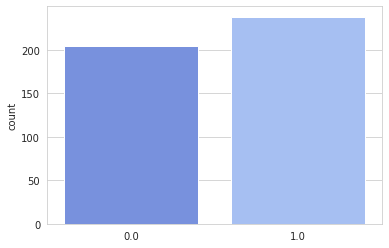

In [31]:
# Getting data

#WINDOWS DAYS = 1
X_irb, y_irb = create_dataframeTfidfTarget(irb_twitter, irb_financas, window_days=1, column='Divide em 0.0')

# using train_test_split random

# using train_test_split NOT RANDOM
size = round(len(X_irb)*0.7)
X_train = X_irb[:size]
X_test = X_irb[size:]
y_train = y_irb[:size]
y_test = y_irb[size:]
sns.countplot(y_irb)
using_all_together(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.61
Acurácia no teste: 0.53
Confusion matrix: 
 [[  0   0]
 [124 141]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.53      0.69       265

    accuracy                           0.53       265
   macro avg       0.50      0.27      0.35       265
weighted avg       1.00      0.53      0.69       265



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_split': 16}
Acurácia treinamento 0.54
Acurácia no teste: 0.53
Confusion matrix: 
 [[  0   0]
 [124 141]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.53      0.69       265

    accuracy                           0.53       265
   macro avg       0.50      0.27      0.35       265
weighted avg       1.00      0.53      0.69       265



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Support Vector Machine
Melhores parâmetros: {'clf__C': 0.01, 'clf__kernel': 'rbf'}
Acurácia treinamento 0.61
Acurácia no teste: 0.53
Confusion matrix: 
 [[  0   0]
 [124 141]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.53      0.69       265

    accuracy                           0.53       265
   macro avg       0.50      0.27      0.35       265
weighted avg       1.00      0.53      0.69       265


Classificador com melhor acurácia no teste: Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


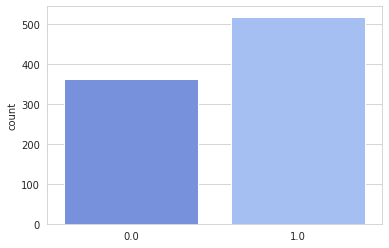

In [32]:
# Getting data

#WINDOWS DAYS = 2
X_irb, y_irb = create_dataframeTfidfTarget(irb_twitter, irb_financas, window_days=2, column='Divide em 0.0')

# using train_test_split random

# using train_test_split NOT RANDOM
size = round(len(X_irb)*0.7)
X_train = X_irb[:size]
X_test = X_irb[size:]
y_train = y_irb[:size]
y_test = y_irb[size:]
sns.countplot(y_irb)
using_all_together(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.64
Acurácia no teste: 0.48
Confusion matrix: 
 [[  0   0]
 [205 190]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.48      0.65       395

    accuracy                           0.48       395
   macro avg       0.50      0.24      0.32       395
weighted avg       1.00      0.48      0.65       395



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_split': 8}
Acurácia treinamento 0.64
Acurácia no teste: 0.48
Confusion matrix: 
 [[  0   0]
 [205 190]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.48      0.65       395

    accuracy                           0.48       395
   macro avg       0.50      0.24      0.32       395
weighted avg       1.00      0.48      0.65       395



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classificador: Support Vector Machine
Melhores parâmetros: {'clf__C': 0.01, 'clf__kernel': 'rbf'}
Acurácia treinamento 0.64
Acurácia no teste: 0.48
Confusion matrix: 
 [[  0   0]
 [205 190]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.48      0.65       395

    accuracy                           0.48       395
   macro avg       0.50      0.24      0.32       395
weighted avg       1.00      0.48      0.65       395


Classificador com melhor acurácia no teste: Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


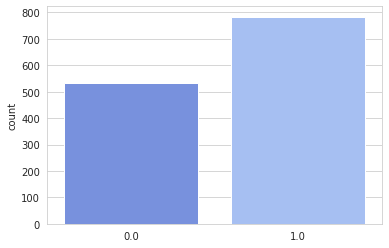

In [33]:
# Getting data

#WINDOWS DAYS = 3
X_irb, y_irb = create_dataframeTfidfTarget(irb_twitter, irb_financas, window_days=3, column='Divide em 0.0')

# using train_test_split random

# using train_test_split NOT RANDOM
size = round(len(X_irb)*0.7)
X_train = X_irb[:size]
X_test = X_irb[size:]
y_train = y_irb[:size]
y_test = y_irb[size:]
sns.countplot(y_irb)
using_all_together(X_train, X_test, y_train, y_test)

### B3 SPLIT

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.78
Acurácia no teste: 0.75
Confusion matrix: 
 [[43  8]
 [21 42]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.67      0.84      0.75        51
         1.0       0.84      0.67      0.74        63

    accuracy                           0.75       114
   macro avg       0.76      0.75      0.75       114
weighted avg       0.76      0.75      0.75       114


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_split': 8}
Acurácia treinamento 0.76
Acurácia no teste: 0.72
Confusion matrix: 
 [[40  8]
 [24 42]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.62      0.83      0.71        48
         1.0       0.84      0.64      0.72  

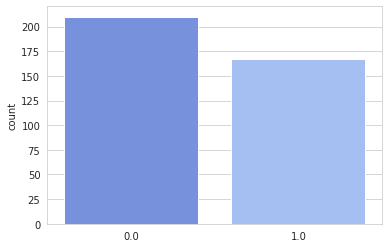

In [47]:
# Getting data

#WINDOWS DAYS = 1 e TRAIN_TEST_SPLIT RANDOM
X_b3, y_b3 = create_dataframeTfidfTarget(b3_twitter, b3_financas, window_days=1, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_b3, y_b3, stratify=y_b3, test_size=0.3, random_state=RANDOM_STATE)
sns.countplot(y_b3)
using_all_together(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.73
Acurácia no teste: 0.75
Confusion matrix: 
 [[115  29]
 [ 28  54]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       144
         1.0       0.65      0.66      0.65        82

    accuracy                           0.75       226
   macro avg       0.73      0.73      0.73       226
weighted avg       0.75      0.75      0.75       226


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_split': 16}
Acurácia treinamento 0.7
Acurácia no teste: 0.74
Confusion matrix: 
 [[114  30]
 [ 29  53]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.80      0.79      0.79       144
         1.0       0.64      0.65      0.64        82

    accuracy          

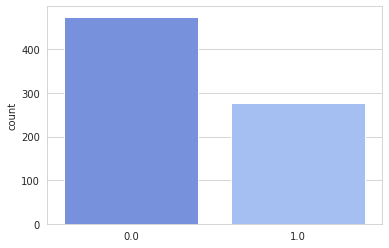

In [48]:
# Getting data

#WINDOWS DAYS = 2 e TRAIN_TEST_SPLIT RANDOM
X_b3, y_b3 = create_dataframeTfidfTarget(b3_twitter, b3_financas, window_days=2, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_b3, y_b3, stratify=y_b3, test_size=0.3, random_state=RANDOM_STATE)
sns.countplot(y_b3)
using_all_together(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 100, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.79
Acurácia no teste: 0.82
Confusion matrix: 
 [[186  27]
 [ 32  80]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.85      0.87      0.86       213
         1.0       0.75      0.71      0.73       112

    accuracy                           0.82       325
   macro avg       0.80      0.79      0.80       325
weighted avg       0.82      0.82      0.82       325


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_split': 16}
Acurácia treinamento 0.78
Acurácia no teste: 0.75
Confusion matrix: 
 [[152  15]
 [ 66  92]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.70      0.91      0.79       167
         1.0       0.86      0.58   

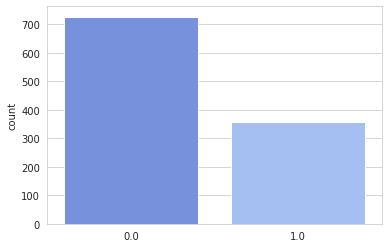

In [49]:
# Getting data

#WINDOWS DAYS = 3 e TRAIN_TEST_SPLIT RANDOM
X_b3, y_b3 = create_dataframeTfidfTarget(b3_twitter, b3_financas, window_days=3, column='Divide em 0.0')

# using train_test_split random
X_train, X_test, y_train, y_test = train_test_split(X_b3, y_b3, stratify=y_b3, test_size=0.3, random_state=RANDOM_STATE)
sns.countplot(y_b3)
using_all_together(X_train, X_test, y_train, y_test)

### B3 NOT SPLIT

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.84
Acurácia no teste: 0.51
Confusion matrix: 
 [[ 1  0]
 [55 57]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.02      1.00      0.04         1
         1.0       1.00      0.51      0.67       112

    accuracy                           0.51       113
   macro avg       0.51      0.75      0.35       113
weighted avg       0.99      0.51      0.67       113



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_split': 8}
Acurácia treinamento 0.84
Acurácia no teste: 0.55
Confusion matrix: 
 [[15 10]
 [41 47]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.27      0.60      0.37        25
         1.0       0.82      0.53      0.65        88

    accuracy                           0.55       113
   macro avg       0.55      0.57      0.51       113
weighted avg       0.70      0.55      0.59       113


Classificador: Support Vector Machine
Melhores parâmetros: {'clf__C': 1.0, 'clf__kernel': 'rbf'}
Acurácia treinamento 0.82
Acurácia no teste: 0.54
Confusion matrix: 
 [[ 7  3]
 [49 54]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.12      0.70      0.21        10
         1.0       0.95      0.52      0.67       103

    accuracy                           0.54       113
 

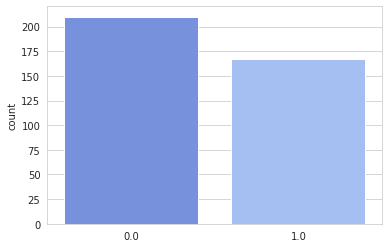

In [50]:
# Getting data

#WINDOWS DAYS = 1
X_b3, y_b3 = create_dataframeTfidfTarget(b3_twitter, b3_financas, window_days=1, column='Divide em 0.0')

# using train_test_split random

# using train_test_split NOT RANDOM
size = round(len(X_b3)*0.7)
X_train = X_b3[:size]
X_test = X_b3[size:]
y_train = y_b3[:size]
y_test = y_b3[size:]
sns.countplot(y_b3)
using_all_together(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...

Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.71
Acurácia no teste: 0.52
Confusion matrix: 
 [[ 13   7]
 [102 104]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.11      0.65      0.19        20
         1.0       0.94      0.50      0.66       206

    accuracy                           0.52       226
   macro avg       0.52      0.58      0.42       226
weighted avg       0.86      0.52      0.62       226


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_split': 8}
Acurácia treinamento 0.71
Acurácia no teste: 0.54
Confusion matrix: 
 [[39 27]
 [76 84]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.34      0.59      0.43        66
         1.0       0.76      0.53      0.6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


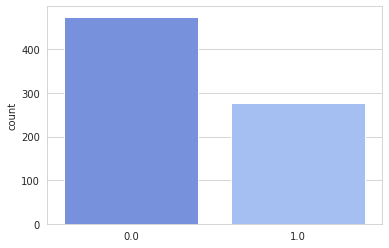

In [51]:
# Getting data

#WINDOWS DAYS = 1
X_b3, y_b3 = create_dataframeTfidfTarget(b3_twitter, b3_financas, window_days=2, column='Divide em 0.0')

# using train_test_split random

# using train_test_split NOT RANDOM
size = round(len(X_b3)*0.7)
X_train = X_b3[:size]
X_test = X_b3[size:]
y_train = y_b3[:size]
y_test = y_b3[size:]
sns.countplot(y_b3)
using_all_together(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Executando pipelines com gridsearch...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Classificador: Logistic Regression
Melhores parâmetros: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia treinamento 0.79
Acurácia no teste: 0.54
Confusion matrix: 
 [[ 62  49]
 [100 114]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.38      0.56      0.45       111
         1.0       0.70      0.53      0.60       214

    accuracy                           0.54       325
   macro avg       0.54      0.55      0.53       325
weighted avg       0.59      0.54      0.55       325


Classificador: Random Forest
Melhores parâmetros: {'clf__criterion': 'gini', 'clf__max_depth': 8, 'clf__min_samples_split': 16}
Acurácia treinamento 0.8
Acurácia no teste: 0.54
Confusion matrix: 
 [[ 64  53]
 [ 98 110]]
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.40      0.55      0.46       117
         1.0       0.67      0.53      0.59       208

    accuracy          

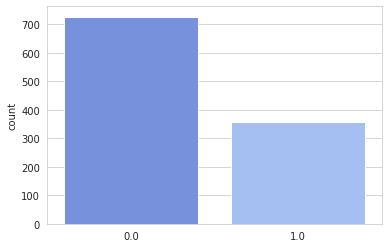

In [52]:
# Getting data

#WINDOWS DAYS = 3
X_b3, y_b3 = create_dataframeTfidfTarget(b3_twitter, b3_financas, window_days=3, column='Divide em 0.0')

# using train_test_split random

# using train_test_split NOT RANDOM
size = round(len(X_b3)*0.7)
X_train = X_b3[:size]
X_test = X_b3[size:]
y_train = y_b3[:size]
y_test = y_b3[size:]
sns.countplot(y_b3)
using_all_together(X_train, X_test, y_train, y_test)